In [1]:
import optuna
import optuna.visualization as ov
from optuna.samplers import TPESampler
import plotly
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pickle
import os
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, f1_score
)


/Users/carlachira/anaconda3/envs/ml_env/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('cleanedData.csv')
data = data.drop("Order", axis = 'columns')
data = data.drop("PID", axis = 'columns')
print(data.shape)
data.head()

(2930, 74)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,HasFence
0,20,RL,141.0,31770,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,0,5,2010,WD,Normal,215000,0
1,20,RH,80.0,11622,1,Reg,Lvl,AllPub,Inside,Gtl,...,0,120,MnPrv,0,6,2010,WD,Normal,105000,1
2,20,RL,81.0,14267,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,12500,6,2010,WD,Normal,172000,0
3,20,RL,93.0,11160,1,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,0,4,2010,WD,Normal,244000,0
4,60,RL,74.0,13830,1,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,MnPrv,0,3,2010,WD,Normal,189900,1


In [158]:
X, y = data.drop("SalePrice", axis = 'columns'), data['SalePrice']
X.head()


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,HasFence
0,20,RL,141.0,31770,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,0,5,2010,WD,Normal,0
1,20,RH,80.0,11622,1,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,MnPrv,0,6,2010,WD,Normal,1
2,20,RL,81.0,14267,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,12500,6,2010,WD,Normal,0
3,20,RL,93.0,11160,1,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,0,4,2010,WD,Normal,0
4,60,RL,74.0,13830,1,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,3,2010,WD,Normal,1


In [159]:
y_classesI = pd.cut(
    y,
    bins=10, 
    labels=False, 
    include_lowest=True 
)
print(y_classesI.head())

0    2
1    1
2    2
3    3
4    2
Name: SalePrice, dtype: int64


In [160]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encodedI = le.fit_transform(y_classesI.dropna())


In [161]:
X_numeric = pd.get_dummies(X) 
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_encodedI, test_size=0.1, random_state=42
)

In [95]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classesI))
    )

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(y_test, y_pred, average='macro')
    return f1


In [96]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=10)


[I 2025-11-17 13:39:21,937] A new study created in memory with name: no-name-d22f648f-f688-4575-bae1-dd251bf5e8bb
[I 2025-11-17 13:39:23,603] Trial 0 finished with value: 0.5182812018078674 and parameters: {'max_depth': 7, 'learning_rate': 0.14062092356827952, 'n_estimators': 285, 'subsample': 0.6865746032924518, 'colsample_bytree': 0.9086106532247759, 'gamma': 4.980255473404755, 'reg_alpha': 0.039509275587271464, 'reg_lambda': 0.4512696494544933}. Best is trial 0 with value: 0.5182812018078674.
[I 2025-11-17 13:39:27,454] Trial 1 finished with value: 0.5266985676032583 and parameters: {'max_depth': 4, 'learning_rate': 0.1924949762493974, 'n_estimators': 680, 'subsample': 0.5736796172892327, 'colsample_bytree': 0.5719299462347631, 'gamma': 0.8178894831585481, 'reg_alpha': 0.5177147098103589, 'reg_lambda': 0.20392414051712515}. Best is trial 1 with value: 0.5266985676032583.
[I 2025-11-17 13:39:31,387] Trial 2 finished with value: 0.5328620184388688 and parameters: {'max_depth': 5, 'lea

In [97]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)


Best Macro F1: 0.5381312894095975
Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.14103625119221652, 'n_estimators': 426, 'subsample': 0.7392733977741588, 'colsample_bytree': 0.5471497681842266, 'gamma': 1.2966516333408062, 'reg_alpha': 0.3768228285931827, 'reg_lambda': 0.4704856576806513}


In [98]:
import nbformat
ov.plot_optimization_history(study).show()
ov.plot_param_importances(study).show()

In [99]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5471497681842266
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [100]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8156996587030717

 f1 score:  0.811398666530199

 Precision: 0.8080259695515044

 Recall 0.8156996587030717

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


In [101]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)


[I 2025-11-17 13:40:33,722] A new study created in memory with name: no-name-fc5eb465-767d-4ac0-895f-01daa5d9be41
[I 2025-11-17 13:40:38,416] Trial 0 finished with value: 0.46106581760727394 and parameters: {'max_depth': 10, 'learning_rate': 0.0315257148746648, 'n_estimators': 556, 'subsample': 0.7906917039123963, 'colsample_bytree': 0.6105752313776013, 'gamma': 1.055374175923545, 'reg_alpha': 0.8641686232862396, 'reg_lambda': 0.3208921330909338}. Best is trial 0 with value: 0.46106581760727394.
[I 2025-11-17 13:40:39,700] Trial 1 finished with value: 0.5348338439745822 and parameters: {'max_depth': 3, 'learning_rate': 0.13743020295893343, 'n_estimators': 201, 'subsample': 0.7073662701403753, 'colsample_bytree': 0.5984377656437698, 'gamma': 1.6208081360561226, 'reg_alpha': 0.00944239219930676, 'reg_lambda': 0.3282332144592198}. Best is trial 1 with value: 0.5348338439745822.
[I 2025-11-17 13:40:41,235] Trial 2 finished with value: 0.46267504108028285 and parameters: {'max_depth': 10, '

In [102]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)


Best Macro F1: 0.5491170948327642
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.07701728674305153, 'n_estimators': 919, 'subsample': 0.510357917482975, 'colsample_bytree': 0.5638781878622887, 'gamma': 1.4337450219145051, 'reg_alpha': 0.058326317971522726, 'reg_lambda': 0.17556029961203487}


In [103]:
ov.plot_optimization_history(study).show()
ov.plot_param_importances(study).show()

In [104]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5638781878622887
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [105]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.825938566552901

 f1 score:  0.8220712337416056

 Precision: 0.8217131862603485

 Recall 0.825938566552901

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


In [106]:
study30 = optuna.create_study(direction='maximize', sampler=TPESampler())
study30.optimize(objective, n_trials=30)

[I 2025-11-17 13:43:49,249] A new study created in memory with name: no-name-0ffefa82-34db-487e-9dfb-7d46364492aa
[I 2025-11-17 13:43:54,426] Trial 0 finished with value: 0.5293305014006843 and parameters: {'max_depth': 8, 'learning_rate': 0.05698018802303395, 'n_estimators': 903, 'subsample': 0.9707667377517901, 'colsample_bytree': 0.5981092471128933, 'gamma': 2.033003298022943, 'reg_alpha': 0.4725432769839252, 'reg_lambda': 0.5586718927432018}. Best is trial 0 with value: 0.5293305014006843.
[I 2025-11-17 13:43:55,599] Trial 1 finished with value: 0.5061151845114666 and parameters: {'max_depth': 6, 'learning_rate': 0.06323553115038696, 'n_estimators': 154, 'subsample': 0.879007961299666, 'colsample_bytree': 0.6780200490491561, 'gamma': 4.021158363067397, 'reg_alpha': 0.8348295308400558, 'reg_lambda': 0.7266177012950132}. Best is trial 0 with value: 0.5293305014006843.
[I 2025-11-17 13:44:00,069] Trial 2 finished with value: 0.4730492506894295 and parameters: {'max_depth': 6, 'learnin

In [107]:
best_trial30 = study30.best_trial
print("Best Macro F1:", best_trial30.value)
print("Best hyperparameters:", best_trial30.params)

Best Macro F1: 0.5483138721644469
Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.07010760288287643, 'n_estimators': 970, 'subsample': 0.7567027379268711, 'colsample_bytree': 0.6389619217251884, 'gamma': 1.01768949336804, 'reg_alpha': 0.5311034389090088, 'reg_lambda': 0.48878011398866106}


In [108]:
best_params30 = best_trial30.params
final_model30 = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model30.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5638781878622887
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [109]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI30 = final_model30.predict(X_test)
y_probI30 = final_model30.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI30))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI30, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI30, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI30, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI30[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.825938566552901

 f1 score:  0.8220712337416056

 Precision: 0.8217131862603485

 Recall 0.825938566552901

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


ROC Curve for Multi-Class XGBoost

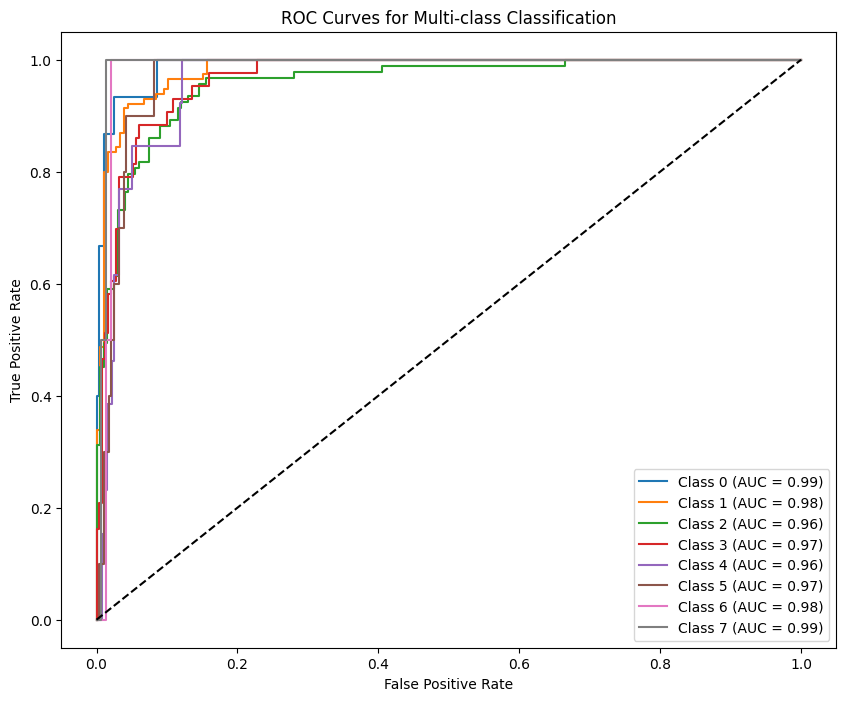

In [110]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probI[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

In [111]:
best_treshold = {}
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_probI[:, i])
    j_scores = tpr - fpr
    best_threshold_index = np.argmax(j_scores)

    best_treshold[i] = {
        'threshold': thresholds[best_threshold_index],
        'tpr': tpr[best_threshold_index],
        'fpr': fpr[best_threshold_index]
    }

print("Best thresholds for each class:")
for cls, vals in best_treshold.items():
    print(f"Class {cls}: Threshold = {vals['threshold']:.4f}, TPR = {vals['tpr']:.4f}, FPR = {vals['fpr']:.4f}")

Best thresholds for each class:
Class 0: Threshold = 0.0259, TPR = 1.0000, FPR = 0.0863
Class 1: Threshold = 0.5797, TPR = 0.9217, FPR = 0.0449
Class 2: Threshold = 0.1655, TPR = 0.9677, FPR = 0.1550
Class 3: Threshold = 0.2397, TPR = 0.8837, FPR = 0.0600
Class 4: Threshold = 0.0536, TPR = 1.0000, FPR = 0.1214
Class 5: Threshold = 0.0079, TPR = 1.0000, FPR = 0.0813
Class 6: Threshold = 0.0300, TPR = 1.0000, FPR = 0.0206
Class 7: Threshold = 0.0160, TPR = 1.0000, FPR = 0.0137


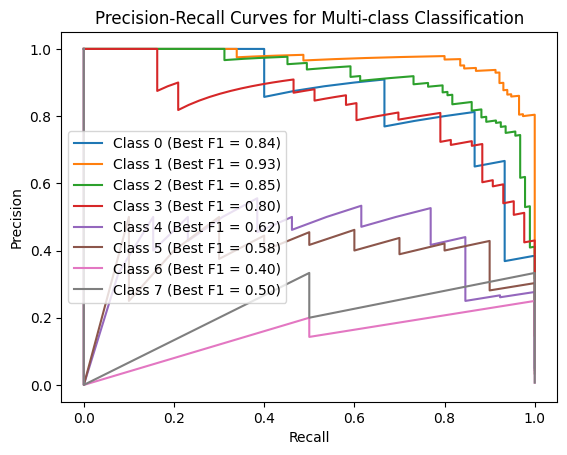

Best PR thresholds per class: {0: np.float32(0.62099916), 1: np.float32(0.579657), 2: np.float32(0.4838692), 3: np.float32(0.36836118), 4: np.float32(0.402954), 5: np.float32(0.019927947), 6: np.float32(0.03004498), 7: np.float32(0.016038034)}


In [112]:
from sklearn.metrics import precision_recall_curve

best_pr_thresholds = {}
n_classes = y_test_bin.shape[1]

plt.figure()
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_probI[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_pr_thresholds[i] = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    plt.plot(recall, precision, label=f'Class {i} (Best F1 = {f1_scores[best_idx]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-class Classification')
plt.legend()
plt.show()
print("Best PR thresholds per class:", best_pr_thresholds)


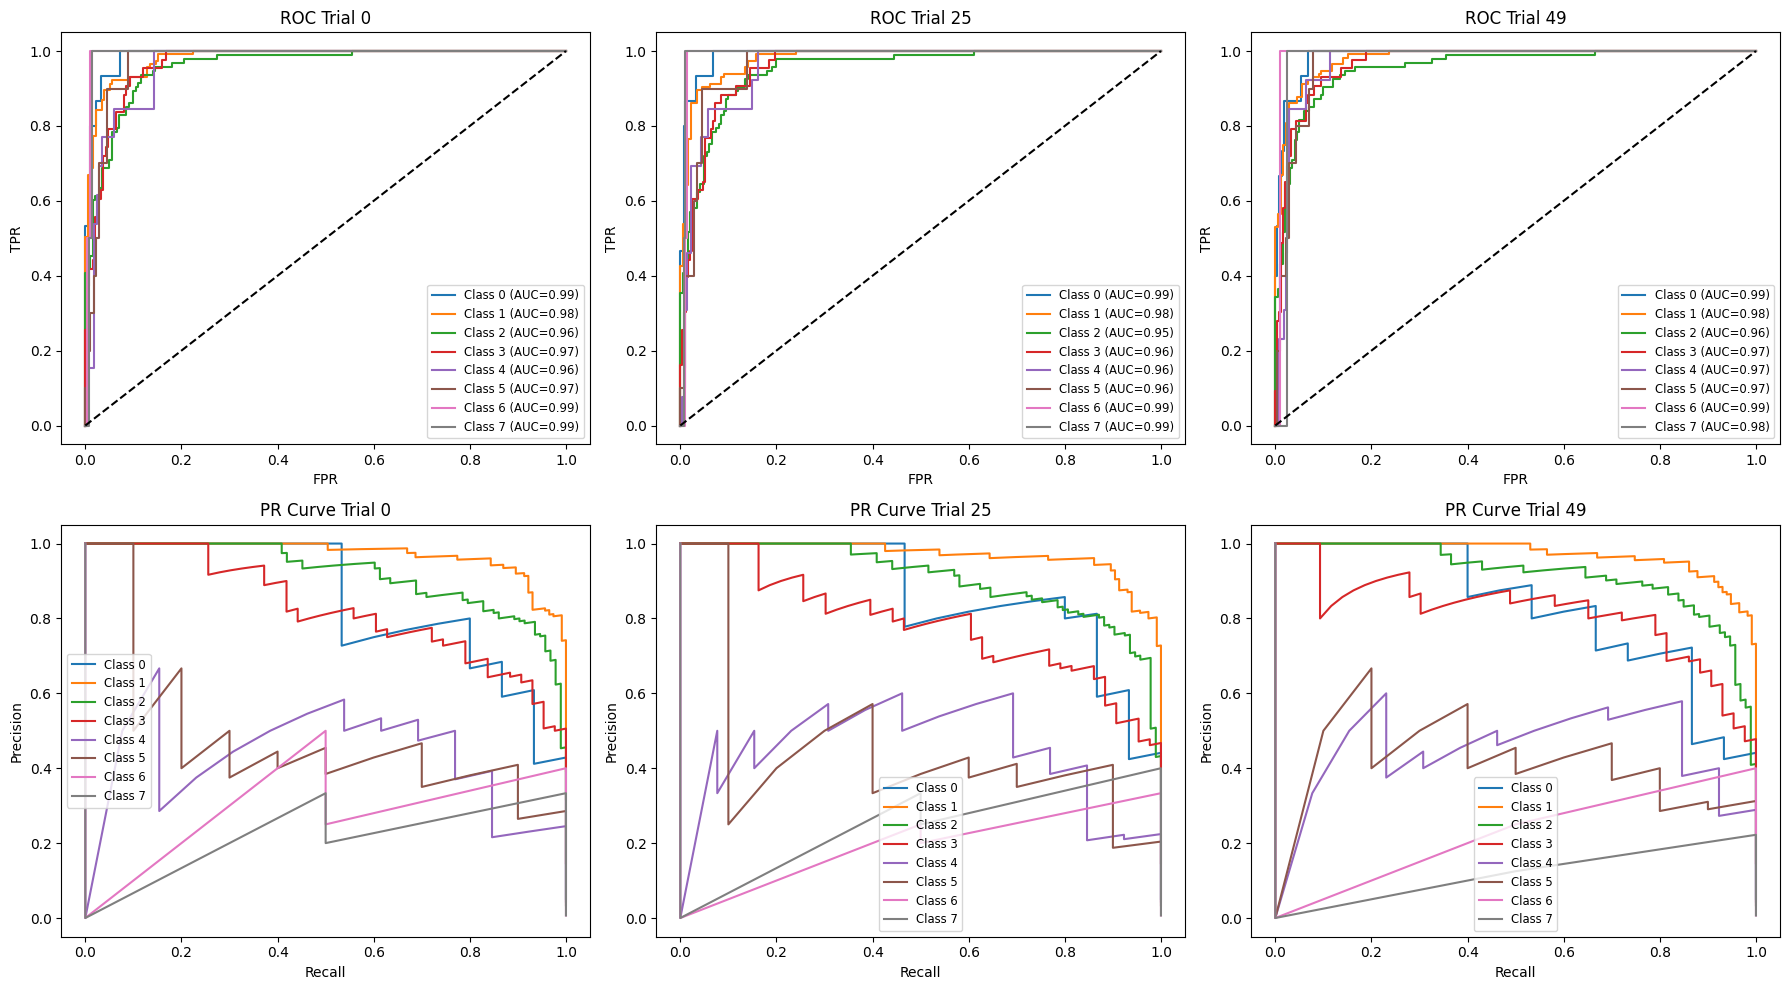

In [113]:
n_classes = y_test_bin.shape[1]
iteration_indices = [0, len(study.trials)//2, len(study.trials)-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for col_idx, trial_idx in enumerate(iteration_indices):
    trial_params = study.trials[trial_idx].params
    iter_model = XGBClassifier(
        **trial_params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=n_classes
    )
    iter_model.fit(X_train, y_train)
    y_prob_iter = iter_model.predict_proba(X_test)
    
    # ROC Curve
    ax_roc = axes[0, col_idx]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_iter[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_title(f'ROC Trial {trial_idx}')
    ax_roc.set_xlabel('FPR')
    ax_roc.set_ylabel('TPR')
    ax_roc.legend(fontsize='small')

    # Precision-Recall Curve
    ax_pr = axes[1, col_idx]
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_iter[:, i])
        ax_pr.plot(recall, precision, label=f'Class {i}')
    ax_pr.set_title(f'PR Curve Trial {trial_idx}')
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.legend(fontsize='small')

plt.tight_layout()
plt.show()


In [15]:
study_name = "dez"
model_dir = f"./artifacts/{study_name}/models"
os.makedirs(model_dir, exist_ok=True)
artifact_store = optuna.artifacts.FileSystemArtifactStore( "./artifacts")


In [16]:
price = data["SalePrice"].copy() #dezechilibru
    
low_thr = price.quantile(0.05)
high_thr = price.quantile(0.95)
    
middle = price[(price >= low_thr) & (price <= high_thr)]
bins = np.linspace(low_thr, high_thr, 9)
    
classes = pd.cut(
    price,
    bins=[-np.inf] + list(bins) + [np.inf],
    labels=list(range(1, 11)),
    include_lowest=True
    )
y_classD = classes.astype(int) - 1
y_classD

0       5
1       1
2       3
3       6
4       4
       ..
2925    2
2926    2
2927    2
2928    3
2929    4
Name: SalePrice, Length: 2930, dtype: int64

In [17]:
class_counts = y_classD.value_counts(normalize=True)
class_weights = 1 / (class_counts ** 0.5)
weights = y_classD.map(class_weights)

In [18]:
Xd = data.drop(columns=["SalePrice"])
Xd = pd.get_dummies(Xd)
X_trainD, X_testD, y_trainD, y_testD = train_test_split(
    Xd, y_classD, 
    stratify=y_classD, 
    test_size=0.1,
    random_state=42
)

In [19]:
weights_train = y_trainD.map(class_weights)
# weights_test = y_testD.map(class_weights)

In [ ]:
def objectiveD(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }


    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classD))
    )

    model.fit(
        X_trainD,
        y_trainD,
        sample_weight=weights_train,
        eval_set=[(X_testD, y_testD)],
        verbose=False
    )

    tmp_path = os.path.join(model_dir, f"model_trial_{trial.number}.pkl")
    with open(tmp_path, "wb") as f:
        pickle.dump(model, f)

    artifact_id = optuna.artifacts.upload_artifact(
        artifact_store=artifact_store,
        file_path=tmp_path,
        study_or_trial=trial
    )
    trial.set_user_attr("artifact_id", artifact_id)

    y_pred_probaD = model.predict_proba(X_testD)
    y_predD = np.argmax(y_pred_probaD, axis=1)

    f1 = f1_score(y_testD, y_predD, average='macro')
    return f1


In [13]:
studyD = optuna.create_study(direction='maximize', sampler=TPESampler())
studyD.optimize(objectiveD, n_trials=200)

[I 2025-11-17 17:22:45,854] A new study created in memory with name: no-name-66f0c5a8-1617-4102-8783-fa4197e8df83
[I 2025-11-17 17:22:48,443] Trial 0 finished with value: 0.5385340015240855 and parameters: {'max_depth': 9, 'learning_rate': 0.29811604035555656, 'n_estimators': 300, 'subsample': 0.9179481354942528, 'colsample_bytree': 0.9061363574154286, 'gamma': 0.14687983757512846, 'reg_alpha': 0.8166497515894614, 'reg_lambda': 0.7174300923917547}. Best is trial 0 with value: 0.5385340015240855.
[I 2025-11-17 17:22:53,555] Trial 1 finished with value: 0.5546854736132152 and parameters: {'max_depth': 10, 'learning_rate': 0.029811976642941728, 'n_estimators': 347, 'subsample': 0.7253524616933457, 'colsample_bytree': 0.9991993304936395, 'gamma': 3.9777282434787815, 'reg_alpha': 0.16050141583971644, 'reg_lambda': 0.66718131768424}. Best is trial 1 with value: 0.5546854736132152.
[I 2025-11-17 17:22:58,143] Trial 2 finished with value: 0.5408084316196163 and parameters: {'max_depth': 5, 'le

In [14]:
best_trialD = studyD.best_trial
print("Best Macro F1:", best_trialD.value)
print("Best hyperparameters:", best_trialD.params)

Best Macro F1: 0.6238844762159783
Best hyperparameters: {'max_depth': 12, 'learning_rate': 0.07211825408959378, 'n_estimators': 247, 'subsample': 0.8279531089303964, 'colsample_bytree': 0.9786351450163375, 'gamma': 4.875737243010248, 'reg_alpha': 0.12575118727459686, 'reg_lambda': 0.7063242092361175}


In [130]:
best_paramsD = best_trialD.params
final_modelD = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classD))
)

final_modelD.fit(X_trainD, y_trainD)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5638781878622887
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [131]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predD = final_modelD.predict(X_testD)
y_probD = final_modelD.predict_proba(X_testD)

print("\n Accuracy:", accuracy_score(y_testD, y_predD))

print("\n f1 score: ", sklearn.metrics.f1_score(y_testD, y_predD, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_testD, y_predD, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_testD, y_predD, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predD[:5])
print(" Actual class labels   :", y_testD[:5])


 Accuracy: 0.6348122866894198

 f1 score:  0.629620697015009

 Precision: 0.6350512122728037

 Recall 0.6348122866894198

 Predicted class labels: [6 2 4 2 2]
 Actual class labels   : 1786    5
2855    2
462     3
2580    2
1870    2
Name: SalePrice, dtype: int64


In [132]:
def load_model_by_trial_number(n):
    trial = studyD.trials[n]
    artifact_id = trial.user_attrs["artifact_id"]
    local_path = f"./artifacts/dez/models/model_loaded_{n}.pkl"
    
    optuna.artifacts.download_artifact(
        artifact_store=artifact_store,
        artifact_id=artifact_id,
        file_path=local_path
    )
    with open(local_path, "rb") as f:
        return pickle.load(f)

first = load_model_by_trial_number(0)
middle = load_model_by_trial_number(len(study.trials)//2)
last = load_model_by_trial_number(len(study.trials)-1)

models = {
    "First Trial": first,
    "Middle Trial": middle,
    "Last Trial": last
}

In [133]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize


def plot_curves(model, X_valid, y_valid, label):

    probs = model.predict_proba(X_valid)
    classes = np.unique(y_valid)


    y_valid_bin = label_binarize(y_valid, classes=classes)

    # ROC
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"ROC Curve – {label}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    roc_info = {}

    for i, cls in enumerate(classes):
        fpr, tpr, thr = roc_curve(y_valid_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.3f})")
        roc_info[cls] = {"fpr": fpr, "tpr": tpr, "thresholds": thr, "auc": roc_auc}

    plt.legend()

    # Precision–Recall curves & best F1 thresholds
    plt.subplot(1, 2, 2)
    plt.title(f"Precision–Recall – {label}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    best_thresholds = {}

    for i, cls in enumerate(classes):
        precision, recall, thr = precision_recall_curve(
            y_valid_bin[:, i], probs[:, i]
        )
        f1 = (2 * precision * recall) / (precision + recall + 1e-12)
        idx = np.argmax(f1)

        best_thr = thr[idx if idx < len(thr) else -1]
        best_thresholds[cls] = best_thr

        plt.plot(recall, precision, label=f"Class {cls}")
        plt.scatter(recall[idx], precision[idx], color="black")

    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_thresholds


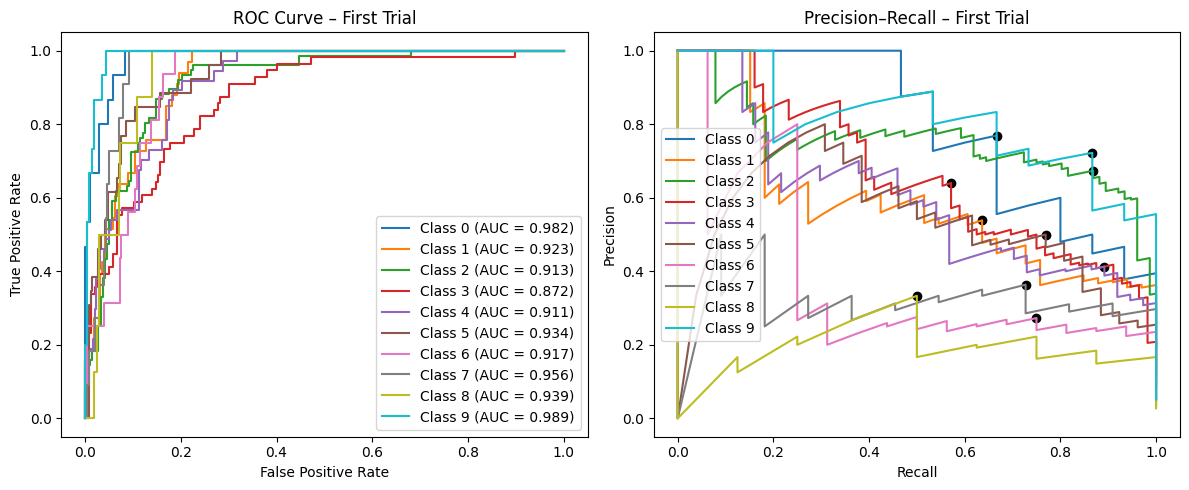

First Trial: Best thresholds per class = {np.int64(0): np.float32(0.22075711), np.int64(1): np.float32(0.34169233), np.int64(2): np.float32(0.25653446), np.int64(3): np.float32(0.45492798), np.int64(4): np.float32(0.11616244), np.int64(5): np.float32(0.16424462), np.int64(6): np.float32(0.09266221), np.int64(7): np.float32(0.25519735), np.int64(8): np.float32(0.12781614), np.int64(9): np.float32(0.2312679)}


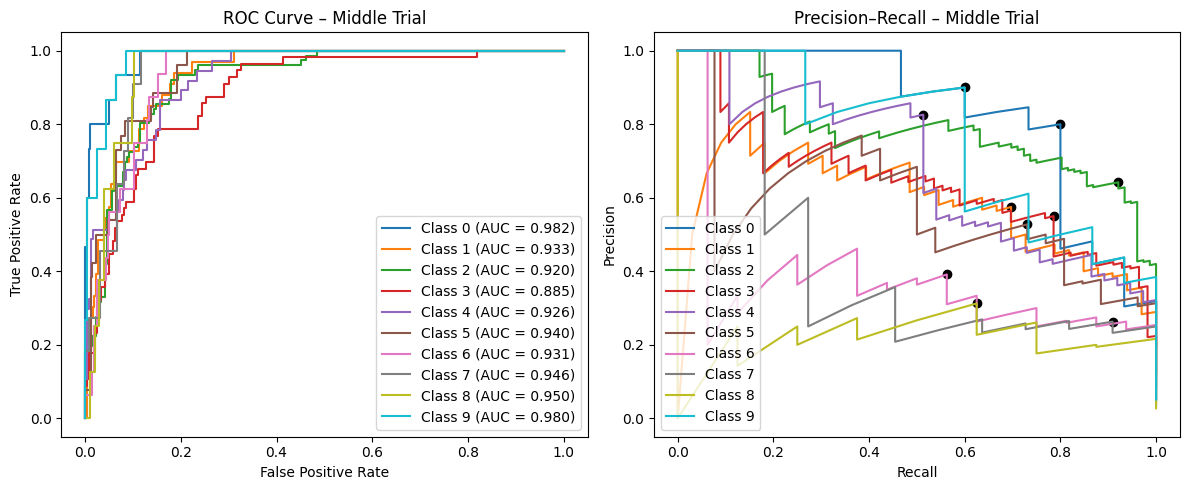

Middle Trial: Best thresholds per class = {np.int64(0): np.float32(0.36246216), np.int64(1): np.float32(0.37224865), np.int64(2): np.float32(0.19670889), np.int64(3): np.float32(0.2748685), np.int64(4): np.float32(0.5125532), np.int64(5): np.float32(0.15469532), np.int64(6): np.float32(0.2849167), np.int64(7): np.float32(0.06607525), np.int64(8): np.float32(0.13114941), np.int64(9): np.float32(0.6507107)}


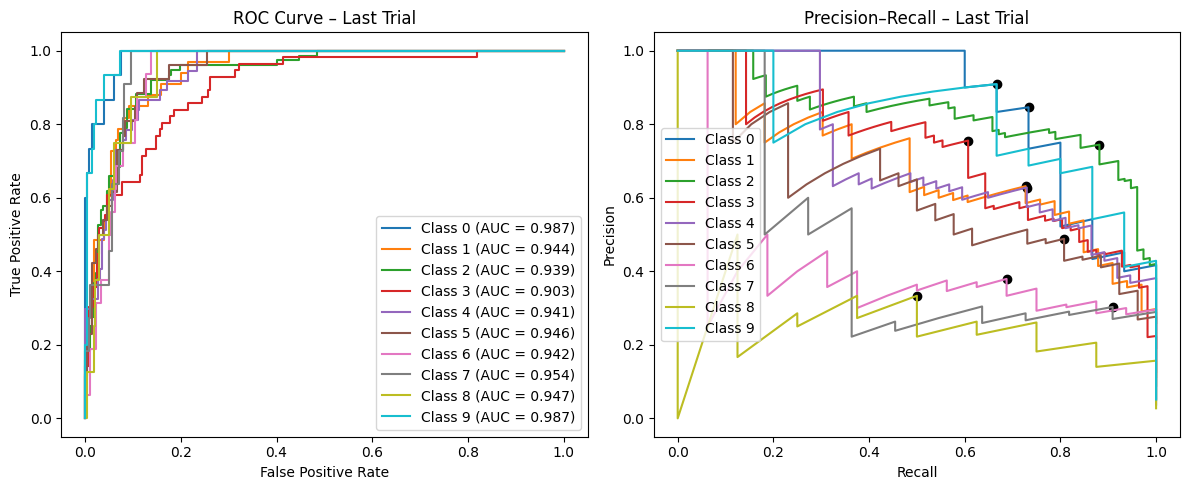

Last Trial: Best thresholds per class = {np.int64(0): np.float32(0.38063073), np.int64(1): np.float32(0.36348733), np.int64(2): np.float32(0.38675043), np.int64(3): np.float32(0.5177148), np.int64(4): np.float32(0.39295277), np.int64(5): np.float32(0.12551592), np.int64(6): np.float32(0.17602775), np.int64(7): np.float32(0.07563223), np.int64(8): np.float32(0.13507535), np.int64(9): np.float32(0.71164644)}


In [134]:

for name, model in models.items():
    best_thresholds = plot_curves(model, X_testD, y_testD, name)
    print(f"{name}: Best thresholds per class = {best_thresholds}")

In [135]:
def objectivePR(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classD))
    )

    model.fit(X_trainD, y_trainD)
    y_pred_proba = model.predict_proba(X_testD)
    y_pred = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(y_testD, y_pred, average='macro')
    return f1

In [136]:
studyPR = optuna.create_study(direction='maximize', sampler=TPESampler())
studyPR.optimize(objectivePR, n_trials=50)

[I 2025-11-17 14:19:51,251] A new study created in memory with name: no-name-0c610430-0902-4666-ada8-eea3c2a4fd7c
[I 2025-11-17 14:19:54,721] Trial 0 finished with value: 0.521681975931925 and parameters: {'max_depth': 10, 'learning_rate': 0.22204248537349336, 'n_estimators': 465, 'subsample': 0.5209302064264367, 'colsample_bytree': 0.5107337441807374, 'gamma': 0.8969290351853654, 'reg_alpha': 0.976027442363731, 'reg_lambda': 0.871921260481069}. Best is trial 0 with value: 0.521681975931925.
[I 2025-11-17 14:19:59,435] Trial 1 finished with value: 0.5129666189985604 and parameters: {'max_depth': 9, 'learning_rate': 0.20631744270176913, 'n_estimators': 916, 'subsample': 0.9461067307383082, 'colsample_bytree': 0.7450507047502366, 'gamma': 1.9540831513572106, 'reg_alpha': 0.5897305650674917, 'reg_lambda': 0.5464308535923103}. Best is trial 0 with value: 0.521681975931925.
[I 2025-11-17 14:20:04,053] Trial 2 finished with value: 0.5275039258799485 and parameters: {'max_depth': 3, 'learning

In [137]:
best_trialPR = studyPR.best_trial
print("Best Macro F1:", best_trialPR.value)
print("Best hyperparameters:", best_trialPR.params)

Best Macro F1: 0.5753232885799222
Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.13515711298530259, 'n_estimators': 741, 'subsample': 0.6794611778468109, 'colsample_bytree': 0.8111070508729514, 'gamma': 2.2709705438366115, 'reg_alpha': 0.6574060427866906, 'reg_lambda': 0.7486851732974561}


In [138]:
best_paramsPR = best_trialPR.params
final_modelPR = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classD))
)

final_modelPR.fit(X_trainD, y_trainD)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5638781878622887
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [139]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predPR = final_modelPR.predict(X_testD)
y_probPR = final_modelPR.predict_proba(X_testD)

y_predPR = np.where(y_probPR[:, 0] > 0.15, 0, y_probPR.argmax(axis=1))
y_predPR = np.where(y_probPR[:, 9] > 0.15, 9, y_probPR.argmax(axis=1))

print("\n Accuracy:", accuracy_score(y_testD, y_predPR))

print("\n f1 score: ", sklearn.metrics.f1_score(y_testD, y_predPR, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_testD, y_predPR, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_testD, y_predPR, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predPR[:5])
print(" Actual class labels   :", y_testD[:5])


 Accuracy: 0.6416382252559727

 f1 score:  0.6276968819969182

 Precision: 0.6292711047500213

 Recall 0.6416382252559727

 Predicted class labels: [6 2 4 2 2]
 Actual class labels   : 1786    5
2855    2
462     3
2580    2
1870    2
Name: SalePrice, dtype: int64


In [140]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predN = final_modelPR.predict(X_testD)
y_probN = final_modelPR.predict_proba(X_testD)

print("\n Accuracy:", accuracy_score(y_testD, y_predN))

print("\n f1 score: ", sklearn.metrics.f1_score(y_testD, y_predN, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_testD, y_predN, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_testD, y_predN, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predN[:5])
print(" Actual class labels   :", y_testD[:5])


 Accuracy: 0.6348122866894198

 f1 score:  0.629620697015009

 Precision: 0.6350512122728037

 Recall 0.6348122866894198

 Predicted class labels: [6 2 4 2 2]
 Actual class labels   : 1786    5
2855    2
462     3
2580    2
1870    2
Name: SalePrice, dtype: int64


In [141]:
ndata = pd.read_csv('incercare.csv')
print(ndata.shape)
ndata.head()

(2922, 170)


,MS SubClass,Lot Frontage,Lot Area,Street,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,0.000000,0.410959,0.142420,1.0,0.0,0.0,0.0,0.555556,0.500,0.637681,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.048246,1.0,1.0,0.0,0.0,0.444444,0.625,0.644928,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,0.205479,0.060609,1.0,0.0,0.0,0.0,0.555556,0.625,0.623188,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.246575,0.046087,1.0,1.0,0.0,0.0,0.666667,0.500,0.695652,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.235294,0.181507,0.058566,1.0,0.0,0.0,0.0,0.444444,0.500,0.905797,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [142]:
nX, ny = ndata.drop("SalePrice", axis = 'columns'), ndata['SalePrice']
nX.head()

,MS SubClass,Lot Frontage,Lot Area,Street,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,0.000000,0.410959,0.142420,1.0,0.0,0.0,0.0,0.555556,0.500,0.637681,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.048246,1.0,1.0,0.0,0.0,0.444444,0.625,0.644928,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,0.205479,0.060609,1.0,0.0,0.0,0.0,0.555556,0.625,0.623188,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.246575,0.046087,1.0,1.0,0.0,0.0,0.666667,0.500,0.695652,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.235294,0.181507,0.058566,1.0,0.0,0.0,0.0,0.444444,0.500,0.905797,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [143]:
ny_classes = pd.cut(
    ny,
    bins=10, 
    labels=False, 
    include_lowest=True 
)
print(ny_classes.head())

0    2
1    1
2    2
3    3
4    2
Name: SalePrice, dtype: int64


In [144]:
ny_encoded = le.fit_transform(ny_classes.dropna())

In [145]:
# nX_numeric = pd.get_dummies(X) 
nX_train, nX_test, ny_train, ny_test = train_test_split(
    nX, ny_encoded, test_size=0.1, random_state=42
)

In [146]:
def nobjective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(ny_classes))
    )

    model.fit(nX_train, ny_train)
    y_pred_proba = model.predict_proba(nX_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(ny_test, y_pred, average='macro')
    return f1

In [147]:
nstudy = optuna.create_study(direction='maximize', sampler=TPESampler())
nstudy.optimize(nobjective, n_trials=50)

[I 2025-11-17 14:27:21,155] A new study created in memory with name: no-name-2f2bd9eb-4561-4cfe-8ae6-74d915865c0e
[I 2025-11-17 14:27:22,351] Trial 0 finished with value: 0.42424684876015184 and parameters: {'max_depth': 12, 'learning_rate': 0.22838993963813845, 'n_estimators': 223, 'subsample': 0.6766511034095453, 'colsample_bytree': 0.9983824139097812, 'gamma': 2.401952955229926, 'reg_alpha': 0.8054059708706404, 'reg_lambda': 0.364158178640708}. Best is trial 0 with value: 0.42424684876015184.
[I 2025-11-17 14:27:26,866] Trial 1 finished with value: 0.40805315004916465 and parameters: {'max_depth': 12, 'learning_rate': 0.07339273109406795, 'n_estimators': 986, 'subsample': 0.8142632790029245, 'colsample_bytree': 0.9848550085578355, 'gamma': 4.530273479222887, 'reg_alpha': 0.6923650853921403, 'reg_lambda': 0.7999666827756441}. Best is trial 0 with value: 0.42424684876015184.
[I 2025-11-17 14:27:28,282] Trial 2 finished with value: 0.3935219341879673 and parameters: {'max_depth': 3, 'l

In [148]:
nbest_trial = study.best_trial
print("Best Macro F1:", nbest_trial.value)
print("Best hyperparameters:", nbest_trial.params)

Best Macro F1: 0.5491170948327642
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.07701728674305153, 'n_estimators': 919, 'subsample': 0.510357917482975, 'colsample_bytree': 0.5638781878622887, 'gamma': 1.4337450219145051, 'reg_alpha': 0.058326317971522726, 'reg_lambda': 0.17556029961203487}


In [149]:
nbest_params = nbest_trial.params
nfinal_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(ny_classes))
)

nfinal_model.fit(nX_train, ny_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5638781878622887
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [150]:
ny_pred = nfinal_model.predict(nX_test)
ny_prob = nfinal_model.predict_proba(nX_test)

print("\n Accuracy:", accuracy_score(ny_test, ny_pred))

print("\n f1 score: ", sklearn.metrics.f1_score(ny_test, ny_pred, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(ny_test, ny_pred, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(ny_test, ny_pred, average='weighted', zero_division=0))

print("\n Predicted class labels:", ny_pred[:5])
print(" Actual class labels   :", ny_test[:5])


 Accuracy: 0.8020477815699659

 f1 score:  0.7938642242749074

 Precision: 0.7964502678892984

 Recall 0.8020477815699659

 Predicted class labels: [3 1 1 3 1]
 Actual class labels   : [3 2 1 3 1]
